# Training Random Forest and DNN for warm-rain process rates

by Stephan Rasp and Axel Seifert

This script includes some additional diagnostic like feature importance and partial dependencies plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xarray
import pandas as pd
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf

In [2]:
tf.__version__

'2.1.0'

## Open data and create X, y

In [3]:
#datadir = '../data/'

datadir = '/Users/axel/DWD/GITLAB/mcsnow/experiments/' 

In [4]:
ds_train = xarray.open_dataset(f'{datadir}autocon_train_big.nc')
ds_test = xarray.open_dataset(f'{datadir}autocon_test_big.nc')

In [5]:
# I just modified this to return accretion and autoconversion (copied from accnorm_v4)
def read_and_prepare_data(fname,auto_sml):
    # Read some data, we just want simple nparrays. Hence the .values
    Lc   = xarray.open_dataset(fname).Lc.values
    Lr   = xarray.open_dataset(fname).Lr.values
    Nc   = xarray.open_dataset(fname).Nc.values
    Nr   = xarray.open_dataset(fname).Nr.values
    nu   = xarray.open_dataset(fname).nu.values
    tau  = xarray.open_dataset(fname).tau.values
    
    auto = xarray.open_dataset(fname).auto_mass.values
    acc  = xarray.open_dataset(fname).accr_mass.values
    
    # some numerical lower bounds
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    auto_min = 1e-15
    
    acc_min = 7e-10
    
    # introduce small but non-zero value for autoconversion into the dataset
    # (this can maybe called "data augmentation", because in that way we keep more data by adding artificial "labels")
    if auto_sml > 0:
        if (auto_sml < 1):
            # small but constant value
            auto = np.where( (Lc > 1e-5) & (auto < auto_sml) & (tau < 0.1),auto_sml,auto)
        else:
            # use autoconversion based on Long kernel. This gives our augmented data the proper scaling
            kcc = 9.44e9     # Long kernel in m3 kg-2 s-1 
            xstar = 2.6e-10    # xstar in kg
            auLg = kcc/(20*xstar) * (nu+2.0)*(nu+4.0)/(nu+1.0)**2 * Lc**2 * (Lc/(Nc+N_min))**2
            auto = np.where( (Lc > 1e-5) & (auto < auLg) & (tau < 0.1),auLg,auto)
    # take out L**2 dependency
    autoL2 = auto * np.power(Lc,-2)
    # transform everything except nu in log space
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Lr = np.log(Lr, where=Lr>L_min)
    
    auto = np.log(auto, where=auto>auto_min, out=np.nan*auto)    
    acc = np.log(acc, where=acc>acc_min, out=np.nan*acc)
    
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [acc.ravel(), auto.ravel(), Lc.ravel(), Xc.ravel(), Lr.ravel(), Xr.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['acc', 'auto','Lc','Xc','Lr','Xr','nu','tau'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [6]:
df_train = read_and_prepare_data(f'{datadir}autocon_train_big.nc', 0)
df_test = read_and_prepare_data(f'{datadir}autocon_test_big.nc', 0)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/pyt

In [7]:
len(df_train), len(df_test)

(165529, 114494)

In [8]:
df_train.describe()

acc           auto             Lc             Xc  \
count  165529.000000  165529.000000  165529.000000  165529.000000   
mean      -16.959038     -21.981218      -8.389516     -25.758783   
std         2.020382       3.485954       1.178864       0.529570   
min       -21.079796     -34.531921     -14.538872     -28.762403   
25%       -18.417715     -24.097206      -8.885702     -26.139458   
50%       -16.908888     -21.436161      -8.479054     -25.821075   
75%       -15.428450     -19.398754      -7.485150     -25.340639   
max       -11.982386     -13.795737      -6.215764     -24.881920   

                  Lr             Xr             nu            tau  
count  165529.000000  165529.000000  165529.000000  165529.000000  
mean      -10.116051     -18.666384       2.004881       0.320530  
std         2.244985       2.277924       1.403198       0.345924  
min       -16.378647     -22.013617       0.000000       0.000039  
25%       -11.899911     -20.547029       1.000000       0.017550  
50%        -9.769840     -19.136318       2.000000       0.150528  
75%        -8.196857     -17.168964       3.000000       0.627656  
max        -6.217121      -9.873302       4.000000       0.998999

In [9]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > 0.99 ].index
    dataset.drop(idx,inplace=True)       
    idx = dataset[ dataset['Lc'] < np.log(0.02e-3) ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [10]:
df_train  = reduce_data(df_train)
df_test = reduce_data(df_test)

In [11]:
len(df_train), len(df_test)

(158521, 109181)

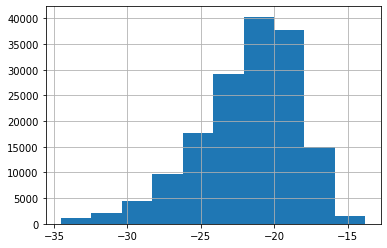

In [12]:
df_train.auto.hist()

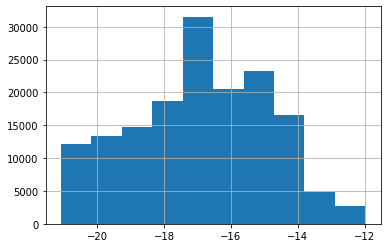

In [13]:
df_train.acc.hist()

Here both rates are the physical unnormalized rates. Accretion is somewhat larger, but not hugely.

In [14]:
# Take all the inputs
Xtrain = df_train[['Lc', 'Xc', 'Lr', 'Xr', 'nu']]
ytrain_auto = df_train['auto']
ytrain_acc = df_train['acc']
ytrain_both = df_train[['auto', 'acc']]
Xtest = df_test[['Lc', 'Xc', 'Lr', 'Xr', 'nu']]
ytest_auto = df_test['auto']
ytest_acc = df_test['acc']
ytest_both = df_test[['auto', 'acc']]

In [15]:
# Normalize
mean = Xtrain.mean()
std = Xtrain.std()

In [16]:
mean, std

(Lc    -8.244443
 Xc   -25.739388
 Lr   -10.225291
 Xr   -18.875019
 nu     2.029750
 dtype: float32,
 Lc    0.964456
 Xc    0.513291
 Lr    2.227306
 Xr    2.071849
 nu    1.399982
 dtype: float32)

In [17]:
Xtrain = (Xtrain - mean) / std
Xtest = (Xtest - mean) / std

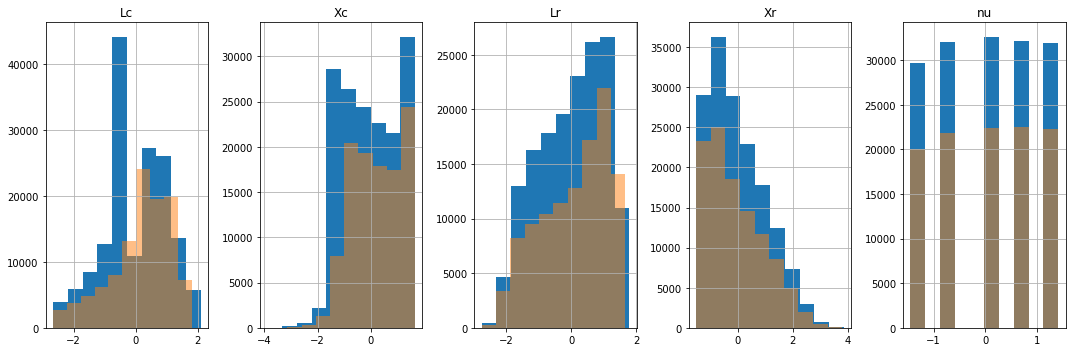

In [18]:
# Just checking if there is enough overlap between training and testing
fig, axs = plt.subplots(1, len(Xtrain.columns), figsize=(15, 5))
for ax, c in zip(axs, Xtrain.columns):
    Xtrain[c].hist(ax=ax)
    Xtest[c].hist(ax=ax, alpha=0.5)
    ax.set_title(c)
plt.tight_layout()

## Random forest

Let's train a random forest, which is basically just a ensemble of decision trees.

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [20]:
# Start with autocon
rf_auto = RandomForestRegressor(
    n_estimators=200,    # Number of trees
    min_samples_leaf=5,  # Min number of samples in each leaf=end node
    n_jobs=20
)

In [21]:
rf_auto.fit(Xtrain, ytrain_auto)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=20, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [22]:
# This is the R2 score = explained variance
# Shows quite a bit of overfitting but that's kind of unavoidable with a RF.
rf_auto.score(Xtrain, ytrain_auto), rf_auto.score(Xtest, ytest_auto)

(0.8442596543826837, 0.6984609561821485)

In [23]:
preds = rf_auto.predict(Xtest)

In [24]:
# Quite a bit worse than your best NNs, which have a score of around 1.09
mean_absolute_error(ytest_auto, preds)

1.1298433236228707

### Now the same for accretion and both at the same time

In [25]:
rf_acc = RandomForestRegressor(
    n_estimators=200,    # Number of trees
    min_samples_leaf=5,  # Min number of samples in each leaf=end node
    n_jobs=20
)
rf_acc.fit(Xtrain, ytrain_acc)
print(rf_acc.score(Xtrain, ytrain_acc), rf_acc.score(Xtest, ytest_acc))
preds = rf_acc.predict(Xtest)
mean_absolute_error(ytest_acc, preds)   # Comprated to 0.12 from accnorm_v4

0.9990005599136904 0.9601471853552401


0.3057904955115203

In [26]:
ytrain_both.std()   # Since they have different stds but are equally important we need to rescale the values

auto    3.396060
acc     2.040376
dtype: float32

In [27]:
scale_au = 1
ytrain_both.loc[:, 'auto'] = ytrain_both['auto'] / scale_au   # Necessary?

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [28]:
ytrain_both.std()   # Since they have different stds but are equally important we need to rescale the values

auto    3.396060
acc     2.040376
dtype: float32

In [29]:
rf_both = RandomForestRegressor(
    n_estimators=200,    # Number of trees
    min_samples_leaf=5,  # Min number of samples in each leaf=end node
    n_jobs=20
)
rf_both.fit(Xtrain, ytrain_both)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=20, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [30]:
# To make the scores comparable we have to scale them back to their original values
preds = rf_both.predict(Xtest)
preds.shape

(109181, 2)

In [31]:
mean_absolute_error(ytest_auto, preds[:, 0]*scale_au)  # Actually a little better than the rf that only predicts auto

1.1359718252119784

In [32]:
mean_absolute_error(ytest_acc, preds[:, 1])

0.313939799804058

### Save the random forest models

How does this work? There is no save function!

In [66]:
#data = 'big'
#rf_auto.save('saved_model/rf_auto_LcXcLrXrNu_v1_'+data) 

#ytrain_stats_auto = ytrain_auto.describe()
#ytrain_stats_auto.to_pickle('saved_model/rf_auto_LcXcLrXrNu_v1_'+data+'_norm.pickle')

In [67]:
#rf_acc.save('saved_model/rf_accr_LcXcLrXrNu_v1_'+data) 

#ytrain_stats_acc = ytrain_acc.describe()
#ytrain_stats_acc.to_pickle('saved_model/rf_auto_LcXcLrXrNu_v1_'+data+'_norm.pickle')

### Feature importance

One interesting thing we can do with a random forest (actually a NN as well) is to check which input feature is most important. The plots below show how much each feature contributes to the final score. Bigger values = more important.

Maybe you can check whether this fits your intuition of the problem.

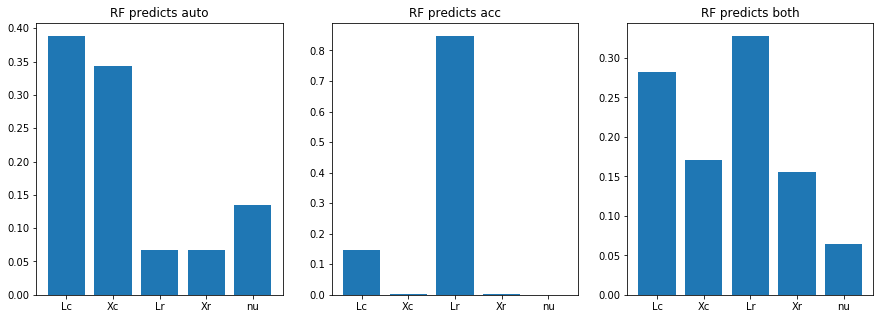

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.bar(Xtrain.columns, rf_auto.feature_importances_); ax1.set_title('RF predicts auto')
ax2.bar(Xtrain.columns, rf_acc.feature_importances_); ax2.set_title('RF predicts acc')
ax3.bar(Xtrain.columns, rf_both.feature_importances_); ax3.set_title('RF predicts both');

In [34]:
# Just a different way of computing this
# But basically same results
from sklearn.inspection import permutation_importance

In [35]:
r = permutation_importance(rf_auto, Xtest, ytest_auto)

<BarContainer object of 5 artists>

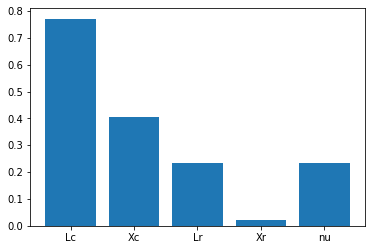

In [36]:
plt.bar(Xtrain.columns, r.importances_mean)

### Partial dependence plot

These plots show how the output of the model changes as the input changes. The way this is computed is by picking a column=feature, e.g. Lc, setting all the rows in this column to one value and then making a prediction. By progressively increasing the value, one can check how the output changes. Then do this for all columns.

BTW, we can also do all these interpretation methods for NNs later.

Again, do the results make physical sense?

In [37]:
from sklearn.inspection import plot_partial_dependence

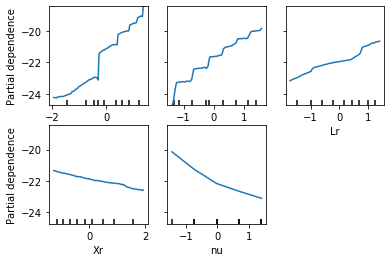

In [38]:
# Auto RF
# Unfortunately, the x label is covered. The first two plots are Lc and Xc
plot_partial_dependence(rf_auto, Xtrain[::100], range(len(Xtrain.columns)), n_jobs=20);

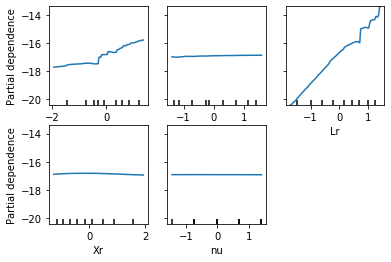

In [39]:
# Acc RF
plot_partial_dependence(rf_acc, Xtrain[::100], range(len(Xtrain.columns)), n_jobs=20);

## Neural network

Ok, now let's tackle neural networks. First, I'll build a very similar network to the one's you built and try to reproduce the scores. Let's start with autoconversion.

In [40]:
from tensorflow.keras.layers import *

In [41]:
model = keras.Sequential([
    Dense(16, input_shape=(5,), activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(1),
])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(tf.keras.optimizers.Adam(1e-3), 'mae')

In [44]:
model.fit(Xtrain, ytrain_auto, epochs=15, batch_size=256, validation_data=(Xtest, ytest_auto))

Train on 158521 samples, validate on 109181 samples
Epoch 1/15
158521/158521 [==============================] - 2s 10us/sample - loss: 11.3132 - val_loss: 3.6227
Epoch 2/15
158521/158521 [==============================] - 1s 7us/sample - loss: 2.5106 - val_loss: 1.2035
Epoch 3/15
158521/158521 [==============================] - 1s 7us/sample - loss: 1.4180 - val_loss: 1.0570
Epoch 4/15
158521/158521 [==============================] - 1s 7us/sample - loss: 1.3005 - val_loss: 1.0331
Epoch 5/15
158521/158521 [==============================] - 1s 7us/sample - loss: 1.2691 - val_loss: 1.0263
Epoch 6/15
158521/158521 [==============================] - 1s 7us/sample - loss: 1.2568 - val_loss: 1.0218
Epoch 7/15
158521/158521 [==============================] - 1s 7us/sample - loss: 1.2500 - val_loss: 1.0232
Epoch 8/15
158521/158521 [==============================] - 1s 7us/sample - loss: 1.2465 - val_loss: 1.0209
Epoch 9/15
158521/158521 [==============================] - 1s 7us/sample - loss: 

So this is about what you got in your notebook. Next, let's try to create a really big net and see if we can get better or overfit.

In [45]:
model = keras.Sequential([
    Dense(256, input_shape=(5,), activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(256, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(1),
])

In [46]:
inp = x = Input((5,))
x = Dense(512, activation='relu')(x)
for _ in range(6):
    skip = x
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Add()([skip, x])
outp = Dense(1)(x)
model = keras.models.Model(inp, outp)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 512)          3072        input_1[0][0]                    
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          262656      dense_12[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 512)          262656      dense_13[0][0]                   
______________________________________________________________________________________________

In [48]:
model.compile(tf.keras.optimizers.Adam(1e-4), 'mae')

In [49]:
model.fit(Xtrain, ytrain_auto/scale_au, epochs=15, batch_size=256, validation_data=(Xtest, ytest_auto/scale_au))

Train on 158521 samples, validate on 109181 samples
Epoch 1/15
158521/158521 [==============================] - 58s 366us/sample - loss: 2.2825 - val_loss: 1.1404
Epoch 2/15
158521/158521 [==============================] - 59s 371us/sample - loss: 1.3041 - val_loss: 1.1639
Epoch 3/15
158521/158521 [==============================] - 61s 382us/sample - loss: 1.2962 - val_loss: 1.3712
Epoch 4/15
158521/158521 [==============================] - 63s 399us/sample - loss: 1.2801 - val_loss: 1.0793
Epoch 5/15
158521/158521 [==============================] - 61s 384us/sample - loss: 1.2829 - val_loss: 1.0622
Epoch 6/15
158521/158521 [==============================] - 59s 370us/sample - loss: 1.2705 - val_loss: 1.0594
Epoch 7/15
158521/158521 [==============================] - 60s 379us/sample - loss: 1.2680 - val_loss: 1.0790
Epoch 8/15
158521/158521 [==============================] - 60s 380us/sample - loss: 1.2637 - val_loss: 1.1208
Epoch 9/15
158521/158521 [==============================] - 

In [50]:
len(Xtrain)

158521

I tried several NN architectures and hyperparameters and was unable to make the model overfit. This is kind of curious. Usually, by increasing the network size, one should be able to at least get lower training scores but this is not the case here. What this suggests to me is that the training data is constructed in a way that doesn't allow the NN to overfit, i.e. memorize the data. So I think the small network pretty much is already the best possible network.

### For accretion

In [51]:
model = keras.Sequential([
    Dense(16, input_shape=(5,), activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(16, activation='tanh'),
    Dense(1),
])

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 16)                96        
_________________________________________________________________
dense_27 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_28 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 657
Trainable params: 657
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(tf.keras.optimizers.Adam(1e-3), 'mae')

In [54]:
model.fit(Xtrain, ytrain_acc, epochs=15, batch_size=256, validation_data=(Xtest, ytest_acc))

Train on 158521 samples, validate on 109181 samples
Epoch 1/15
158521/158521 [==============================] - 2s 10us/sample - loss: 5.8348 - val_loss: 1.2390
Epoch 2/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.5199 - val_loss: 0.1210
Epoch 3/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.0875 - val_loss: 0.0638
Epoch 4/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.0661 - val_loss: 0.0597
Epoch 5/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.0629 - val_loss: 0.0573
Epoch 6/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.0616 - val_loss: 0.0556
Epoch 7/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.0608 - val_loss: 0.0534
Epoch 8/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0.0606 - val_loss: 0.0561
Epoch 9/15
158521/158521 [==============================] - 1s 7us/sample - loss: 0

In fact, I seem to get slightly worse values compared to your notebook. I still need to investigate why.

### Predict both

In [55]:
model = keras.Sequential([
    Dense(128, input_shape=(5,), activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(128, activation='tanh'),
    Dense(2),
])

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_32 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 258       
Total params: 34,050
Trainable params: 34,050
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(tf.keras.optimizers.Adam(1e-3), 'mae')

In [58]:
model.fit(Xtrain, ytrain_both, epochs=15, batch_size=256)

Train on 158521 samples
Epoch 1/15
158521/158521 [==============================] - 2s 12us/sample - loss: 2.1196
Epoch 2/15
158521/158521 [==============================] - 2s 11us/sample - loss: 0.6604
Epoch 3/15
158521/158521 [==============================] - 2s 11us/sample - loss: 0.6565
Epoch 4/15
158521/158521 [==============================] - 2s 10us/sample - loss: 0.6545
Epoch 5/15
158521/158521 [==============================] - 2s 13us/sample - loss: 0.6533
Epoch 6/15
158521/158521 [==============================] - 2s 11us/sample - loss: 0.6533
Epoch 7/15
158521/158521 [==============================] - 2s 12us/sample - loss: 0.6519
Epoch 8/15
158521/158521 [==============================] - 2s 10us/sample - loss: 0.6515
Epoch 9/15
158521/158521 [==============================] - 2s 10us/sample - loss: 0.6517
Epoch 10/15
158521/158521 [==============================] - 2s 10us/sample - loss: 0.6513
Epoch 11/15
158521/158521 [==============================] - 2s 10us/sample

In [59]:
preds = model.predict(Xtest)

In [60]:
preds = model.predict(Xtest)
preds.shape

(109181, 2)

In [61]:
mean_absolute_error(ytest_auto, preds[:, 0]*scale_au) 

1.018637

In [62]:
mean_absolute_error(ytest_acc, preds[:, 1])

0.057834376

Not better for the NN case. So all this leaves me to conclude that small networks are absolutely sufficient for the dataset and, in terms of netowrk architectures, you alread got the most out of the data!